<a href="https://colab.research.google.com/github/suredream/PyTorch-Lightning-Ace/blob/main/pll-cnn-aug-ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning==1.6.2 --quiet
!pip install torch==1.11.0 --quiet

     |████████████████████████████████| 582 kB 6.9 MB/s 
     |████████████████████████████████| 140 kB 52.5 MB/s 
     |████████████████████████████████| 596 kB 50.3 MB/s 
     |████████████████████████████████| 419 kB 54.9 MB/s 
     |████████████████████████████████| 1.1 MB 44.4 MB/s 
     |████████████████████████████████| 271 kB 52.9 MB/s 
     |████████████████████████████████| 144 kB 54.5 MB/s 
     |████████████████████████████████| 94 kB 3.4 MB/s 


In [2]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/utils/kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json
!pip install -q kaggle 

!kaggle datasets download ardamavi/sign-language-digits-dataset
!unzip sign-language-digits-dataset.zip -d sign-language-digits-dataset > /dev/null

 59% 10.0M/16.8M [00:00<00:00, 45.2MB/s]
100% 16.8M/16.8M [00:00<00:00, 68.6MB/s]


In [3]:
import numpy as np
import pandas as pd
import torch.nn.functional as F
import math
from torch.optim import lr_scheduler
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import metrics
import torch
import itertools
from torchvision import models
import torch.optim as optim
from matplotlib.ticker import MaxNLocator
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from torch import nn
from torch.utils.data import Dataset, DataLoader
import os
from torch.nn import MaxPool2d
# import chainer.links as L
from PIL import Image
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
plt.ion()

import pytorch_lightning as pl
from torchmetrics.functional import accuracy

# Processing the dataset

In [5]:
data = np.load('sign-language-digits-dataset/X.npy')
target = np.load('sign-language-digits-dataset/Y.npy')
Y = np.zeros(data.shape[0])
Y[:204] = 9
Y[204:409] = 0
Y[409:615] = 7
Y[615:822] = 6
Y[822:1028] = 1
Y[1028:1236] = 8
Y[1236:1443] = 4
Y[1443:1649] = 3
Y[1649:1855] = 2
Y[1855:] = 5
X_train, X_test, y_train, y_test = train_test_split(data, Y, test_size = .02, random_state = 2) ## splitting into train and test set

In [6]:
class SignDigitDataset(Dataset):
    
    #initialise the class variables - transform, data, target
    def __init__(self, data, target, transform=None): 
        self.transform = transform
        self.data = data.reshape((-1,64,64)).astype(np.float32)[:,:,:,None]
        # converting target to torch.LongTensor dtype
        self.target = torch.from_numpy(target).long() 
    
    #retrieve the X and y index value and return it
    def __getitem__(self, index): 
        return self.transform(self.data[index]), self.target[index]
    
    #returns the length of the data
    def __len__(self): 
        return len(list(self.data))

In [7]:
# preprocessing images and performing operations sequentially
# Firstly, data is converted to PILImage, Secondly, converted to Tensor
# Thirdly, data is Normalized
transform = transforms.Compose(
    [transforms.ToPILImage(), transforms.ToTensor()])
dset_train = SignDigitDataset(X_train, y_train, transform)
train_dataloader = DataLoader(dset_train, batch_size=4, shuffle=True, num_workers=4)

In [8]:
dset_test = SignDigitDataset(X_test, y_test, transform)
test_dataloader = DataLoader(dset_test, batch_size=4,shuffle=True, num_workers=4)

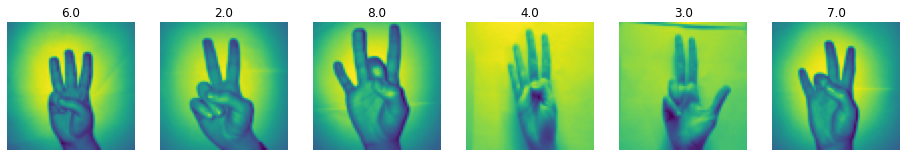

In [9]:
plt.figure(figsize = (16, 4))
for num, x in enumerate(X_train[0:6]):
    plt.subplot(1,6,num+1)
    plt.axis('off')
    plt.imshow(x)
    plt.title(y_train[num])

# Model

In [10]:
class CNNImageClassifier(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.cnn_layers = nn.Sequential(
            # Defining a 2D convolution layer
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            # Putting a 2D Batchnorm after CNN layer
            nn.BatchNorm2d(32),
            # Adding Relu Activation
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
          
        self.linear_layers = nn.Sequential(
            # Adding Dropout
            nn.Dropout(p = 0.5),
            nn.Linear(32 * 32 * 32, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(p = 0.5),
            nn.Linear(512, 10),
        )
        self.loss = nn.CrossEntropyLoss()
        self.save_hyperparameters()

    # Defining the forward pass    
    def forward(self, x):
        
        # Forward Pass through the CNN Layers 
        x = self.cnn_layers(x)
        x = x.view(x.size(0), -1)
        # Forwrd pass through Fully Connected Layers
        x = self.linear_layers(x)
        return F.log_softmax(x) 

    def configure_optimizers(self):
        params = self.parameters()
        optimizer = optim.Adam(params=params)
        return optimizer

    def training_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self(inputs) 
        train_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('train_accuracy', train_accuracy, prog_bar=True)
        self.log('train_loss', loss)
        return {"loss":loss, "train_accuracy": train_accuracy}

    def test_step(self, batch, batch_idx):
        inputs, targets = batch
        outputs = self.forward(inputs)
        test_accuracy = accuracy(outputs, targets)
        loss = self.loss(outputs, targets)
        self.log('test_accuracy', test_accuracy)
        return {"test_loss":loss, "test_accuracy":test_accuracy}

    def predict_step(self, batch, batch_idx ):
        return self(batch)

In [11]:
model = CNNImageClassifier()

trainer = pl.Trainer(fast_dev_run=True, gpus=0)
trainer.fit(model, train_dataloaders=train_dataloader)

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Running in fast_dev_run mode: will run a full train, val, test and prediction loop using 1 batch(es).
`Trainer(limit_train_batches=1)` was configured so 1 batch per epoch will be used.
`Trainer(limit_val_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_test_batches=1)` was configured so 1 batch will be used.
`Trainer(limit_predict_batches=1)` was configured so 1 batch will be used.
`Trainer(val_check_interval=1.0)` was configured so validation will run at the end of the training epoch..

  | Name          | Type             | Params
---------------------------------------------------
0 | cnn_layers    | Sequential       | 9.7 K 
1 | linear_layers | Sequential       | 16.8 M
2 | loss          | CrossEntropyLoss | 0     
---------------------------------------------------
16.8 M    Trainable params
0         Non-trainable para

Training: 0it [00:00, ?it/s]

In [13]:
ckpt_dir = "/content/drive/MyDrive/Colab Notebooks/cnn-sign-digits"
ckpt_callback = pl.callbacks.ModelCheckpoint(every_n_epochs=25)

model = CNNImageClassifier()
trainer = pl.Trainer(
    default_root_dir=ckpt_dir,
                     gpus=-1,
                    #  progress_bar_refresh_rate=30,
                        callbacks=[ckpt_callback],
                        log_every_n_steps=25,
                        max_epochs=5)
trainer.fit(model, train_dataloaders=train_dataloader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | cnn_layers    | Sequential       | 9.7 K 
1 | linear_layers | Sequential       | 16.8 M
2 | loss          | CrossEntropyLoss | 0     
---------------------------------------------------
16.8 M    Trainable params
0         Non-trainable params
16.8 M    Total params
67.174    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

# model predictions

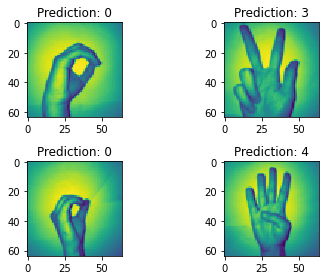

In [17]:
_, (validation_data, target) = next(enumerate(test_dataloader))
with torch.no_grad():
    output = model(validation_data)
fig = plt.figure()
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.tight_layout()
    plt.imshow(validation_data[i][0], interpolation='none')
    pred = output.data.max(1, keepdim=True)[1][i].item()
    plt.title("Prediction: {}".format(pred))

#  Predicted Probabilities of the predicted words

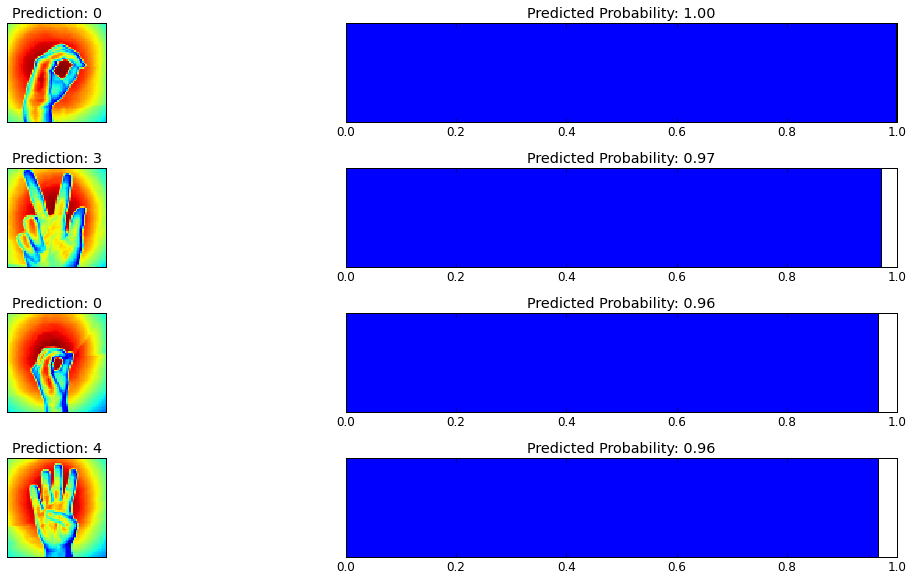

In [18]:
with torch.no_grad():
    output = model(validation_data)

softmax = torch.exp(output).cpu()
prob = list(softmax.numpy())

fig = plt.figure(figsize = (16, 8))
for i in range(0, 4):
    fig.tight_layout()
    plt.style.use('classic')
    plt.subplot(4,2, 2 * i + 1)
    plt.imshow(validation_data[i][0], interpolation='none')
    plt.xticks([])
    plt.yticks([])
    pred = output.data.max(1, keepdim=True)[1][i].item()
    plt.title("Prediction: {}".format(pred))
    plt.subplot(4,2, 2 * i + 2)
    plt.barh([0], [max(prob[i])])
    plt.yticks([])
    plt.title("Predicted Probability: {0:.2f}".format(max(prob[i])))

# Data Augmentation

In [20]:
train_transform= transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomHorizontalFlip(), # Horizontal Flip
            transforms.RandomCrop(64, padding=2), # Centre Crop
            transforms.ToTensor(),  #Convereting the input to tensor
            ])
dset_train = SignDigitDataset(X_train, y_train, train_transform)
train_dataloader = DataLoader(dset_train, batch_size=4, shuffle=True, num_workers=4)